In [1]:
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
data_path = 'out_data'

In [3]:
# function to get the label from the file name
def get_label_from_filename(filename):
    label = filename.split('-')[0]
    return label

In [4]:
# load the files into a dataframe
def load_files_to_dataframe(data_path):
    data = []
    for filename in os.listdir(data_path):
        label = get_label_from_filename(filename)
        image_path = os.path.join(data_path, filename)
        image = Image.open(image_path)
        data.append({'image': image, 'label': label,})
    return pd.DataFrame(data)

In [5]:
df = load_files_to_dataframe(data_path)
print(df.head(20))

                                                image          label
0   <PIL.PngImagePlugin.PngImageFile image mode=RG...  7039610000318
1   <PIL.PngImagePlugin.PngImageFile image mode=RG...  7037206100022
2   <PIL.PngImagePlugin.PngImageFile image mode=RG...           4015
3   <PIL.PngImagePlugin.PngImageFile image mode=RG...           4196
4   <PIL.PngImagePlugin.PngImageFile image mode=RG...  7040513000022
5   <PIL.PngImagePlugin.PngImageFile image mode=RG...  7037206100022
6   <PIL.PngImagePlugin.PngImageFile image mode=RG...  7038010021145
7   <PIL.PngImagePlugin.PngImageFile image mode=RG...           4196
8   <PIL.PngImagePlugin.PngImageFile image mode=RG...  7035620058776
9   <PIL.PngImagePlugin.PngImageFile image mode=RG...  7023026089401
10  <PIL.PngImagePlugin.PngImageFile image mode=RG...  7040913336684
11  <PIL.PngImagePlugin.PngImageFile image mode=RG...          94011
12  <PIL.PngImagePlugin.PngImageFile image mode=RG...  7020097009819
13  <PIL.PngImagePlugin.PngImageFi

In [6]:
# split into train and test sets for X and Y 

X = df['image']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Efficientnet

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [8]:
def preprocess_images(images, target_size=(224, 224)):
    processed_images = []
    for img in images:
        img = img.resize(target_size)
        img_array = img_to_array(img)
        img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
        processed_images.append(img_array)
    return np.array(processed_images)

In [9]:
X_train_processed = preprocess_images(X_train)
X_test_processed = preprocess_images(X_test)

In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Number of classes
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")

Number of classes: 26
Classes: ['4011' '4015' '4088' '4196' '7020097009819' '7020097026113'
 '7023026089401' '7035620058776' '7037203626563' '7037206100022'
 '7038010009457' '7038010013966' '7038010021145' '7038010054488'
 '7038010068980' '7039610000318' '7040513000022' '7040513001753'
 '7040913336684' '7044610874661' '7048840205868' '7071688004713'
 '7622210410337' '90433917' '90433924' '94011']


In [11]:
def create_model(num_classes):
    # Load EfficientNetB0 with pre-trained weights (excluding top layers)
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Add custom classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    return model

In [12]:
model = create_model(num_classes)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    'efficientnet_best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [14]:
history = model.fit(
    X_train_processed,
    y_train_encoded,
    batch_size=32,
    epochs=10,
    validation_split=0.2,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.7087 - loss: 1.2779
Epoch 1: val_accuracy improved from -inf to 0.98237, saving model to efficientnet_best_model.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 61s 368ms/step - accuracy: 0.7098 - loss: 1.2733 - val_accuracy: 0.9824 - val_loss: 0.0964
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9888 - loss: 0.0662
Epoch 2: val_accuracy improved from 0.98237 to 0.99279, saving model to efficientnet_best_model.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 53s 340ms/step - accuracy: 0.9888 - loss: 0.0662 - val_accuracy: 0.9928 - val_loss: 0.0451
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9940 - loss: 0.0327
Epoch 3: val_accuracy did not improve from 0.99279
156/156 ━━━━━━━━━━━━━━━━━━━━ 51s 329ms/step - accuracy: 0.9940 - loss: 0.0327 - val_accuracy: 0.9904 - val_loss: 0.0355
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9960 - loss: 0.0193
Epoch 4: val_accuracy improved from 0.99279 to 0.99519, saving model to efficientnet_best_model.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 54s 346ms/step - accuracy: 0.9960 - loss: 0.0193 - val_accuracy: 0.9952 - val_loss: 0.0288
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9992 - loss: 0.0113
Epoch 5: val_accuracy did not improve from 0.99519
156/156 ━━━━━━━━━━━━━━━━━━━━ 53s 337ms/step - accuracy: 0.9992 - loss: 0.0113 - val_accuracy: 0.9920 - val_loss: 0.0251
Epoch 6/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9995 - loss: 0.0072
Epoch 6: val_accuracy did not improve from 0.99519
156/156 ━━━━━━━━━━━━━━━━━━━━ 54s 349ms/step - accuracy: 0.9994 - loss: 0.0072 - val_accuracy: 0.9936 - val_loss: 0.0219
Epoch 7/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9987 - loss: 0.0078
Epoch 7: val_accuracy improved from 0.99519 to 0.99599, saving model to efficientnet_best_model.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 53s 343ms/step - accuracy: 0.9987 - loss: 0.0078 - val_accuracy: 0.9960 - val_loss: 0.0184
Epoch 8/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9998 - loss: 0.0050
Epoch 8: val_accuracy did not improve from 0.99599
156/156 ━━━━━━━━━━━━━━━━━━━━ 53s 339ms/step - accuracy: 0.9998 - loss: 0.0050 - val_accuracy: 0.9944 - val_loss: 0.0175
Epoch 9/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9995 - loss: 0.0055
Epoch 9: val_accuracy did not improve from 0.99599
156/156 ━━━━━━━━━━━━━━━━━━━━ 53s 341ms/step - accuracy: 0.9995 - loss: 0.0055 - val_accuracy: 0.9952 - val_loss: 0.0211
Epoch 10/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9992 - loss: 0.0039
Epoch 10: val_accuracy did not improve from 0.99599
156/156 ━━━━━━━━━━━━━━━━━━━━ 52s 334ms/step - accuracy: 0.9992 - loss: 0.0039 - val_accuracy: 0.9952 - val_loss: 0.0132
Restoring model weights from the end of the best epoch: 7.


In [15]:
test_loss, test_accuracy = model.evaluate(X_test_processed, y_test_encoded)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 259ms/step - accuracy: 0.9926 - loss: 0.0158
Test accuracy: 0.9955
Test loss: 0.0172


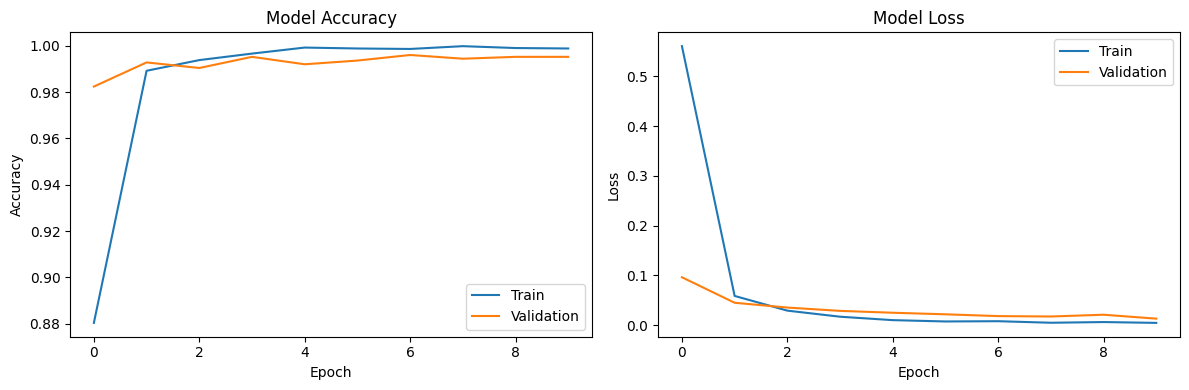

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [17]:
y_pred = model.predict(X_test_processed)
y_pred_classes = np.argmax(y_pred, axis=1)

49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 269ms/step


In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(classification_report(y_test_encoded, y_pred_classes, target_names=label_encoder.classes_))

               precision    recall  f1-score   support

         4011       1.00      1.00      1.00        70
         4015       1.00      0.98      0.99        56
         4088       0.98      1.00      0.99        54
         4196       1.00      1.00      1.00        60
7020097009819       1.00      1.00      1.00        77
7020097026113       1.00      1.00      1.00        60
7023026089401       1.00      1.00      1.00        55
7035620058776       1.00      1.00      1.00        64
7037203626563       1.00      1.00      1.00        68
7037206100022       1.00      1.00      1.00        60
7038010009457       1.00      1.00      1.00        56
7038010013966       1.00      1.00      1.00        65
7038010021145       1.00      1.00      1.00        57
7038010054488       1.00      1.00      1.00        57
7038010068980       1.00      1.00      1.00        54
7039610000318       1.00      1.00      1.00        48
7040513000022       1.00      1.00      1.00        46
704051300

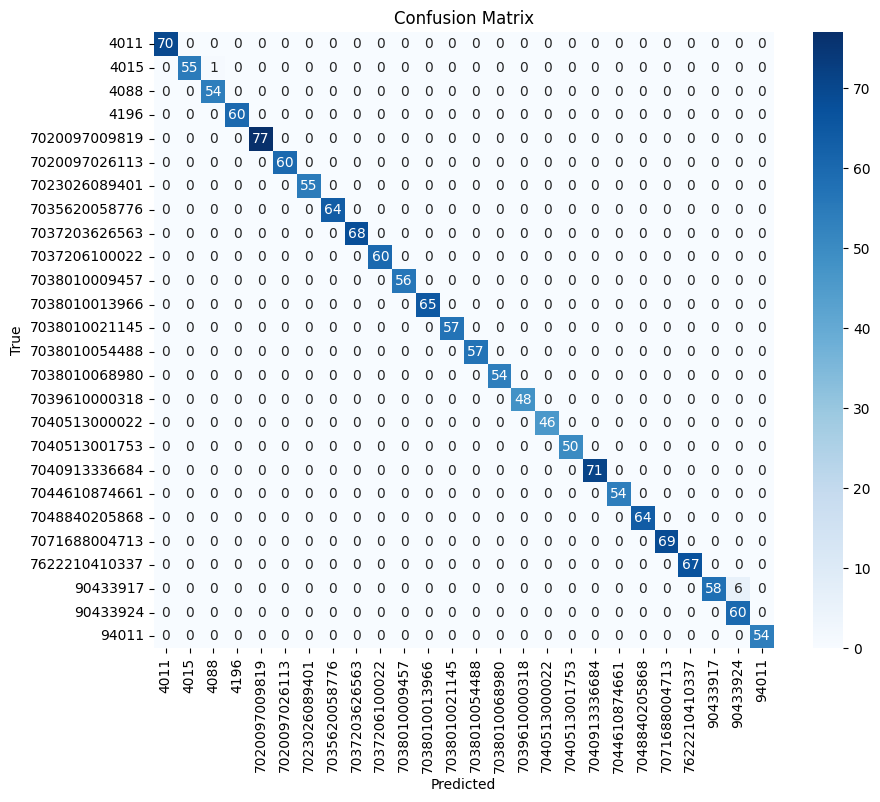

In [19]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_encoded, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()